In [1]:
import os
from flask import Flask, flash, request, redirect, url_for, send_from_directory
from werkzeug.utils import secure_filename
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import csv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data_df = pd.read_csv('data.csv')
data_df

,plot_id,cotton_px
0,plotid_102,2979
1,plotid_103,9203
2,plotid_105,27811
3,plotid_105,27811
4,plotid_105,27811
5,plotid_105,27811
6,plotid_105,27811
7,plotid_105,27811
8,plotid_105,27811
9,plotid_105,27811


In [3]:
"<pre>"+ data_df.to_string()+ "</pre>"

'<pre>      plot_id  cotton_px\n0  plotid_102       2979\n1  plotid_103       9203\n2  plotid_105      27811\n3  plotid_105      27811\n4  plotid_105      27811\n5  plotid_105      27811\n6  plotid_105      27811\n7  plotid_105      27811\n8  plotid_105      27811\n9  plotid_105      27811</pre>'

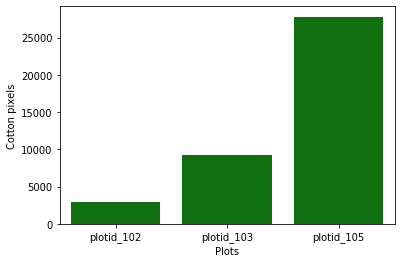

In [95]:
from io import BytesIO
import base64

ax = sns.barplot(x = "plot_id", y = "cotton_px", data = data_df, color='green')
ax.set(xlabel="Plots", ylabel = "Cotton pixels")
fig=plt.gcf()

im_buf_arr = BytesIO()
fig.savefig(im_buf_arr,format='png')
im_buf_arr.seek(0)
b64data = base64.b64encode(im_buf_arr.read()).decode('utf8');

AttributeError: 'str' object has no attribute 'datatype'

In [86]:
fig.savefig('im_buf_arr.png')

NameError: name 'imshow' is not defined

In [48]:
b64data = base64.b64encode((plt.gcf().savefig(im_buf_arr,format='png')).read()).decode('utf8');
b64data

AttributeError: 'NoneType' object has no attribute 'read'

<Figure size 432x288 with 0 Axes>

In [25]:
from flask import render_template
from io import BytesIO
import base64
im_buf_arr = BytesIO()
plt.gcf().savefig(im_buf_arr,format='png')
im_buf_arr.seek(0)
b64data = base64.b64encode(im_buf_arr.read()).decode('utf8');
render_template('templates/img.html',img_data=b64data) 


AttributeError: 'NoneType' object has no attribute 'app'

<Figure size 432x288 with 0 Axes>

In [3]:
def greenExtract(img):
    # Convert BGR to RGB
    RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    #color space splitting
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    #R,G,B = cv.split(RGB)

    Rnorm = cv.normalize(R, None, 0, 1, cv.NORM_MINMAX, cv.CV_32FC1)
    Gnorm = cv.normalize(G, None, 0, 1, cv.NORM_MINMAX, cv.CV_32FC1)
    Bnorm = cv.normalize(B, None, 0, 1, cv.NORM_MINMAX, cv.CV_32FC1)

    #original green extraction
    #ExR = 1.4*Rnorm - Gnorm;
    #ExG = 1.5*Gnorm - Rnorm - Bnorm;

    #cotton pixels pre-segmentation
    #optimum cotton pixels preprocessing
    ExR = 2.0*Rnorm - Gnorm;
    ExG = 1.5*Gnorm - Rnorm - Bnorm;
    
    ExR = cv.normalize(ExR, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    thR, ExR = cv.threshold(ExR, 0, 255, cv.THRESH_OTSU);
    ExR = ExR.astype(np.int16)

    ExG = cv.normalize(ExG, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    thG, ExG = cv.threshold(ExG, 0, 255, cv.THRESH_OTSU);
    ExG = ExG.astype(np.int16)
    
    img_noGreen = cv.normalize(cv.normalize(np.subtract(ExG,ExR) * -1, 
                            None, 0, 1, cv.NORM_MINMAX) * 255, None, 0,
                            255, cv.NORM_MINMAX,cv.CV_8U)
    rgb_cotton = cv.bitwise_and(RGB,RGB,mask = img_noGreen)
    bgr_cotton = cv.cvtColor(rgb_cotton, cv.COLOR_RGB2BGR)

    #green pixels segmentation based on Excess Green index
    #optimum green pixels extraction
    ExR_opt = 1.0*Rnorm - 0.8*Gnorm;
    ExG_opt = 1.5*Gnorm - Rnorm - Bnorm;
    ExR_opt = cv.normalize(ExR_opt, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    thR_opt, ExR_opt = cv.threshold(ExR_opt, 0, 255, cv.THRESH_OTSU);
    ExR_opt = ExR_opt.astype(np.int16)

    ExG_opt = cv.normalize(ExG, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    thG_opt, ExG_opt = cv.threshold(ExG_opt, 0, 255, cv.THRESH_OTSU);
    ExG_opt = ExG_opt.astype(np.int16)

    img_green = cv.normalize(cv.normalize(np.subtract(ExG_opt,ExR_opt), 
                            None, 0, 1, cv.NORM_MINMAX) * 255, None, 0,
                            255, cv.NORM_MINMAX,cv.CV_8U)

    rgb_leaves = cv.bitwise_and(RGB,RGB,mask = img_green)

    return bgr_cotton, rgb_leaves

In [4]:
def colorSpaces(img):
# This function performs the color space conversion
# input: BGR image
# output: HSV and Lab color space images
    # Convert BGR to HSV
    HSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    #display(Image.fromarray(HSV))
    #H,S,V = cv.split(HSV)
    # Convert BGR to CIELab
    Lab=cv.cvtColor(img,cv.COLOR_BGR2LAB)
    #display(Image.fromarray(Lab))
    #L,a,b = cv.split(Lab)
    
    return (HSV,Lab)

In [119]:
def createValidationDF(HSV,Lab):
# This function creates the dataset for model validation:
# inputs: HSV and Lab color space images
# output: daframe for validation, incluing H, S, V, a, b color channel components
    #Create HSV subset
    index = pd.MultiIndex.from_product(
        (*map(range, HSV.shape[:2]), ('H', 'S', 'V')),
        names=('row', 'col', None))
    # HSV color channels extraction
    df2 = pd.Series(HSV.flatten(), index=index)
    df2 = df2.unstack()
    df2 = df2.reset_index().reindex(columns=['row', 'col', 'H', 'S', 'V'])
    
    #Create CIE Lab subset
    index = pd.MultiIndex.from_product(
        (*map(range, Lab.shape[:2]), ('L', 'a', 'b')),
        names=('row', 'col', None))
    # Lab color channels extraction
    df3 = pd.Series(Lab.flatten(), index=index)
    df3 = df3.unstack()
    df3 = df3.reset_index().reindex(columns=['row', 'col', 'L', 'a', 'b'])

    # Merge HSV and Lab subsets using pixel location (row, col)
    df = pd.merge(df2, df3, on=['row', 'col'])
    
    #reduce number of points by deleting not presegmented cotton pixels
    df_temp = df.copy()
    #create pre-segmented cotton pixels datframe
    df_cotton = df_temp[(df_temp['H'] > 0)&(df_temp['S'] > 0)&(df_temp['V'] >= 0)] 

    return df, df_cotton   

In [221]:
clf = joblib.load('./SVM_model_HSVab.pkl')
            
# Read image
img = cv.imread('uploads/plotid_909.png')
                
# Create dataframe
#green pixels preprocecssing extraction
image_cotton, image_leaves = greenExtract(img)
                    
# Save green pixels mask (leaves)
Image.fromarray(image_leaves)
            
#color spaces creation
HSV,Lab = colorSpaces(image_cotton)
#create dataframe for validation
full_data, cotton_data = createValidationDF(HSV,Lab)
 
# Results verification
# Drop pixel position columns (row, and col), and L column
X = cotton_data.drop(['row','col','L'], axis = 1)

In [222]:
# Apply SVM model for pixels classification    
y_pred = clf.predict(X)

In [223]:
cotton_data

,row,col,H,S,V,L,a,b
0,0,0,6,72,74,65,135,133
1,0,1,8,60,76,71,132,133
2,0,2,7,72,78,70,134,134
3,0,3,8,64,76,70,133,133
4,0,4,11,67,80,76,132,135
...,...,...,...,...,...,...,...,...
508741,313,116,15,27,76,79,129,131
508742,313,117,12,44,75,74,130,132
508743,313,118,23,31,66,69,127,132
508744,313,119,10,32,72,73,130,131


In [224]:
y_pred

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

In [225]:
# Create prediction mask
cotton_df = cotton_data.copy()
#recover pixel indices
cotton_df.insert(0,'cotton', y_pred, True)
cotton_df = pd.DataFrame(cotton_df.iloc[:,0])
cotton_df[cotton_df['cotton']=='no'] = 0
cotton_df[cotton_df['cotton']=='yes'] = 255
#pred_mask.insert(1, 'col', cotton_data.reset_index()['col'], True)
cotton_df

,cotton
0,0
1,0
2,0
3,0
4,0
...,...
508741,0
508742,0
508743,0
508744,0


In [226]:
#reconstruct image dataframe
full_mask = full_data.copy()
full_mask['cotton']=0
full_mask = pd.DataFrame(full_mask.iloc[:,-1])
full_mask.update(cotton_df)
full_mask

,cotton
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
510245,0.0
510246,0.0
510247,0.0
510248,0.0


In [227]:
# Change the dtype to 'uint8'
full_mask = (full_mask.astype('uint8')).to_numpy()

In [228]:
mask_.shape

(594864, 1)

In [229]:
# Convert from array to image pixels
h,w,c = image_cotton.shape
h,w,c

(314, 1625, 3)

In [230]:
mask_result = np.reshape(full_mask,(h,w))
mask_result.shape

(314, 1625)

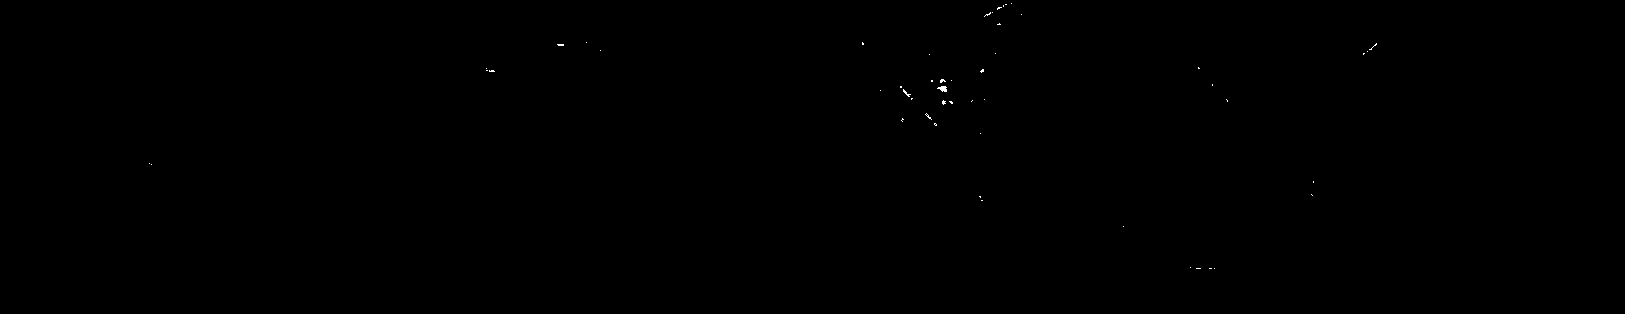

In [231]:
Image.fromarray(mask_result)